In [15]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import math
import random

(256, 256)


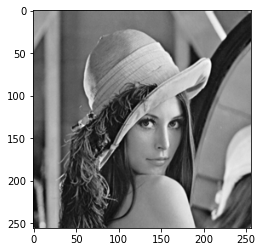

In [17]:
img = plt.imread('LENA.bmp')
# img = plt.imread('gray.jpg')
plt.imshow(img, cmap='gray')
print(img.shape)

In [16]:
#计算信噪比
#psnr = 10*lg(MAX^2 / MSE)
def psnr(img1, img2):
   mse = np.mean( (img1/255. - img2/255.) ** 2 )
   if mse < 1.0e-10:
      return 100
   PIXEL_MAX = 1
   return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

#计算恢复图像后像素错误数量
def err(img, img1):
    tmp = img.copy()
    tmp[tmp == img1] = 0
    tmp[tmp > 0] = 1
    return np.sum(tmp)
   

In [29]:
# 判断是否是可扩展的
def isScalable(h, b, l):
    return np.abs(2 * h + b) <= min(2 * (255 - l), 2 * l + 1)

# 判断是否是可改变的
def isCvtible(h, l):
    return np.abs(2 * (h // 2) + 1) <= min(2 * (255 - l), 2 * l + 1) # and np.abs(2 * (h // 2) + 0) <= min(2 * (255 - l), 2 * l + 1)

# EZ包含所有可扩展的差值 h ＝０和h ＝－１
def EZ(h, b, l):
    return isScalable(h, b, l) and (h == 0 or h == -1)

# EN包含所有可扩展的差值 h ∉ EZ
# EN1中h <= T
def EN1(h, b, l, T = 10):
    return isScalable(h, b, l) and h != 0 and h != -1 and h <= T

# EN2中h > T
def EN2(h, b, l, T = 10):
    return isScalable(h, b, l) and h != 0 and h != -1 and h > T

# CN包含所有可改变的差值 h ∉ EZ ∪ EN 
def CN(h, b, l):
    return not isScalable(h, b, l) and isCvtible(h, l)

# NC包含所有不可改变的差值 
def NC(h, b, l):
    return not isCvtible(h, b, l)

In [30]:
# 嵌入像素, 返回嵌入得到的像素组(x1, y1), 差值的LSB, 以及标志位, 它意味着是否嵌入成功
# l = x + y
# h = x - y
# x = l + ⌊(h + 1)/2⌋
# y = l - ⌊h/2⌋
def embed(x, y, w):
    l = (np.int32(x) + y) // 2
    h = np.int32(x) - y
    h1 = 0
    flag1 = flag2 = False
    if EZ(h, w, l) or EN1(h, w, l):
        h1 = 2 * h + w
        flag1 = True
    elif EN2(h, w, l) or CN(h, w, l):
        h1 = 2 * (h // 2) + w
        # print('h, h1:',h,h1)
        flag2 = True
    else:
        return x, y, h & 0x1, flag1, flag2
    x1 = l + (h1 + 1) // 2
    y1 = l - h1 // 2
    # print("l, h, h1, x1, y1:")
    # print(l, h, h1, x1, y1)
    
    # 嵌入结果
    return np.uint8(x1), np.uint8(y1), h & 0x1, flag1, flag2

# 提取像素, 返回原来的像素组(x, y) 以及嵌入信息w
def extract(x, y, loc, lsb):
    l = (np.int32(x) + y) // 2
    h = h1 = np.int32(x) - y
    w = 0
    flag1 = flag2 = False
    if loc == 1:
        w = h1 & 0x1
        h = h1 // 2
        flag1 = True
        # 将像素组以同样的大小关系返回回去 
    elif isCvtible(h1, l):
        w = h1 & 0x1
        h = 2 * (h1 // 2) + lsb
        flag2 = True
    else: 
        return 0, 0, 0, flag1, flag2
    x1 = l + (h + 1) // 2
    y1 = l - h // 2
    # print("l, h, h1, x1, y1:")
    # print(l, h, h1, x1, y1)
    
    # print(type(np.uint8(x1)))
    return np.uint8(x1), np.uint8(y1), w, flag1, flag2

x = 75
y = 58
print('x, y:', x,y)
w = 0
x1, y1, lsb, ret1, ret2 = embed(x, y, w)
print("x1, y1, w, lsb:", x1, y1, w, lsb, ret1, ret2)
x2, y2, w, ret3, ret4= extract(x1, y1, ret1, lsb)
print("x2, y2, w:", x2, y2, w, ret3, ret4)

In [32]:
# Difference Expansion算法
def diffExp(img, bits):
    loc = np.zeros(img.shape[0] * img.shape[1] // 2, dtype = 'b')
    LSBs = []
    img1 = img.copy()
    # print(img.shape)
    row, col = img.shape
    w = bits.copy()
    k = len(bits)
    st = 0
    for r in range(0, row):
        if st >= k:
            break
        for c in range(0, col, 2):
            x1, y1, lsb, ret1, ret2 = embed(img[r][c], img[r][c + 1], w[st])
            if ret1:
                loc[(r * img.shape[1] + c) // 2] = 1
                img1[r][c] = x1
                img1[r][c + 1] = y1
                st += 1
            elif ret2:
                img1[r][c] = x1
                img1[r][c + 1] = y1
                st += 1
                LSBs.append(lsb)
            if st >= k:
                break
    return img1, loc, LSBs


In [33]:
def deDiffExp(img, loc, LSBs):
    res = []
    k = sum(loc) + len(LSBs)
    img1 = img.copy()
    row, col = img.shape
    for r in range(0, row):
        if len(res) >= k:
            break
        for c in range(0, col, 2):
            lsb = 0
            if len(LSBs) > 0:
                lsb = LSBs[0]
            x1, y1, w, ret1, ret2 = extract(img1[r][c], img1[r][c + 1], loc[(r * img.shape[1] + c) // 2], lsb)
            if ret1:
                img1[r][c] = x1
                img1[r][c + 1] = y1
                res.append(w)
                if len(res) >= k:
                    break
            elif ret2:
                img1[r][c] = x1
                img1[r][c + 1] = y1
                
                LSBs.pop(0)
                res.append(w)
                if len(res) >= k:
                    break
    return img1, res


53.775329618388234
100
2576
0
错误率: 0.0


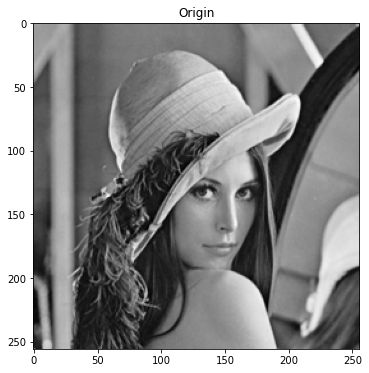

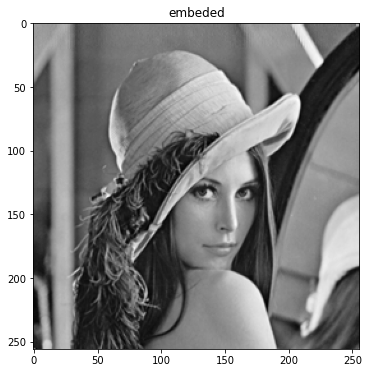

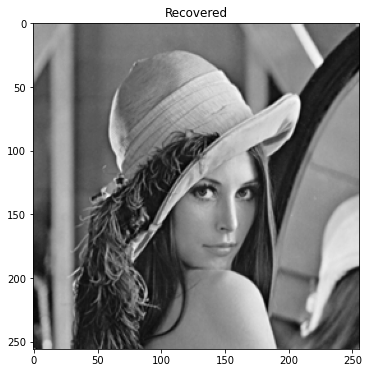

In [34]:
plt.figure(figsize=(6,6))
plt.title('Origin')
plt.imshow(img, cmap='gray')

B = 0x993532abcdefbac35787098abdc986786993532abcdefbac35787098abdc9867865452465bac9993532abcdefbac35787098abdc9867865452465bac98759856104819034d89179857590710875985993532abcde993532abcdefbac35787098abdc9867865452465bac98759856104819034d89179857590710fbac35787098abdc9867865452465bac98759856104819034d891798575907106104819034d891798575907105452465bac98759856104819034d8917985759071095710957197591759017597190571857197993532abcdefbac35787098abdc9867865452465bac9875985610481993532abcdefbac35787098abdc9867865452465bac98759856104819034d891798575907109034d89179857590710591759993532abcdefbac35787098abdc9867865452465bac98759856104819034d89179857590710015
strB = bin(B)[2:]
listb = [int(strb) for strb in strB]
img1, loc, LSBs = diffExp(img, listb)
plt.figure(figsize=(6,6))
plt.title('embeded')
plt.imshow(img1, cmap='gray')
print(psnr(img, img1))
img2, res = deDiffExp(img1, loc, LSBs)
plt.figure(figsize=(6,6))
plt.title('Recovered')
plt.imshow(img2, cmap='gray')
print(psnr(img, img2))

print(len(bin(B)) - 2)
print(err(img, img2))
print('错误率:', err(img, img2) / (len(bin(B)) - 2))

In [35]:
# 固定图像以及图像大小, 测试不同信息长度下的psnr与错误数量
BitsLen = []
Psnr = []
Res = []
W = []
l = 1
while l < 2**16:
    w = []
    while len(w) < l:
        w.append(np.random.randint(2)) 
    img1, loc, LSBs = diffExp(img, w)
    img2, res = deDiffExp(img1, loc, LSBs)
    BitsLen.append(len(w))
    Psnr.append(psnr(img1, img))
    Res.append(res)
    W.append(w)
    l *= 2

0


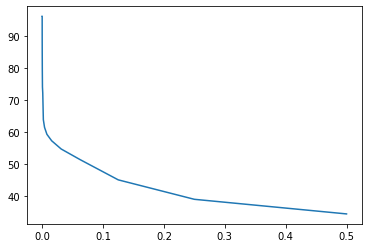

In [36]:
sum1 = 0
for i in range(len(Res)):
    if Res[i] != W[i]:
        # for j in range(len(bin(Res[i])) - 1,2,-1):
        #     if(bin(Res[i])[j] != bin(W[i])[j]):
        #         print(len(bin(Res[i])) - 2)
        #         print(j - 2)
        #         break
        # print(i)
        sum1 += 1
print(sum1)

tmp = [BitsLen[i] / img.size for i in range(len(BitsLen))]
plt.plot(tmp, Psnr)

True
32768
32768
34.33957831365192
100


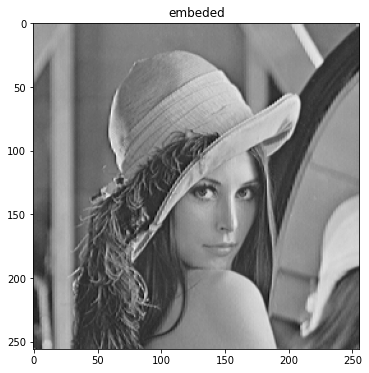

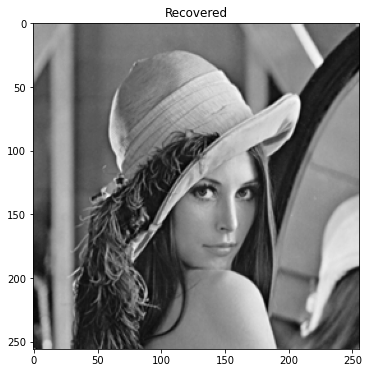

In [41]:
l = 2**15
w1 = []
while len(w1) < l:
    w1.append(np.random.randint(2))
img1, loc, LSBs = diffExp(img, w1)
img2, res = deDiffExp(img1, loc, LSBs)
print(res == w1)
print(len(res))
print(len(w1))

plt.figure(figsize=(6,6))
plt.title('embeded')
plt.imshow(img1, cmap='gray')
print(psnr(img, img1))
plt.figure(figsize=(6,6))
plt.title('Recovered')
plt.imshow(img2, cmap='gray')
print(psnr(img, img2))

print('错误率:',err(img, img1) / img.size)
print('嵌入率:',len(w1) / img.size)

r = 7
c = 250
print(loc[(r * img.shape[1] + c) // 2])
# x1, y1, w, ret = extract(img1[r][c], img1[r][c + 1], loc[(r * img.shape[1] + c) // 2])
print(img[r][c], img[r,c+1])
print(img1[r][c], img1[r,c+1])
print(img2[r][c],img2[r][c+1])

x = 75
y = 58
print('x, y:', x,y)
w = 1
x1, y1, lsb, ret1, ret2 = embed(x, y, w)
print("x1, y1, w, lsb:", x1, y1, w, lsb, ret1, ret2)
x2, y2, w, ret3, ret4= extract(x1, y1, ret1, lsb)
print("x2, y2, w:", x2, y2, w, ret3, ret4)

In [39]:
# 校正码 
# 二值位置图压缩 jbig标准
# 实现每一种文件的嵌入 jpeg